In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.3, 0.3],
    c1 = 2.0,
    c2 = 2.0,
    w = 1.2,
    w_decay = 0,
    scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 800
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8580246913580247, Loss: 0.6189472763626663
Checkpoint 200, Accuracy: 0.8580246913580247, Loss: 0.584980222913954
Checkpoint 300, Accuracy: 0.8580246913580247, Loss: 0.5791450076633029
Checkpoint 400, Accuracy: 0.8641975308641975, Loss: 0.5642046398586698
Checkpoint 500, Accuracy: 0.8765432098765432, Loss: 0.5700352280228226
Checkpoint 600, Accuracy: 0.8703703703703703, Loss: 0.5747015211317275
Checkpoint 700, Accuracy: 0.8518518518518519, Loss: 0.5808621159306279
Checkpoint 800, Accuracy: 0.8518518518518519, Loss: 0.5808621159306279


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

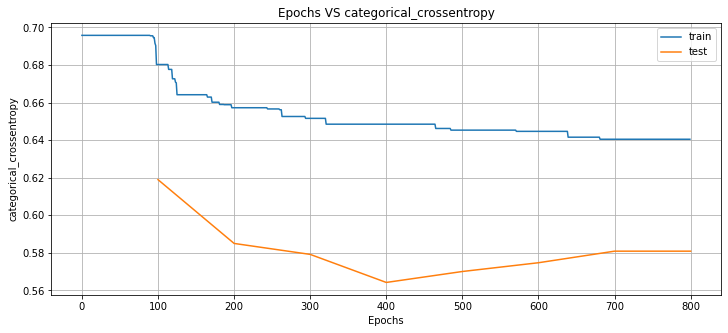

In [10]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])

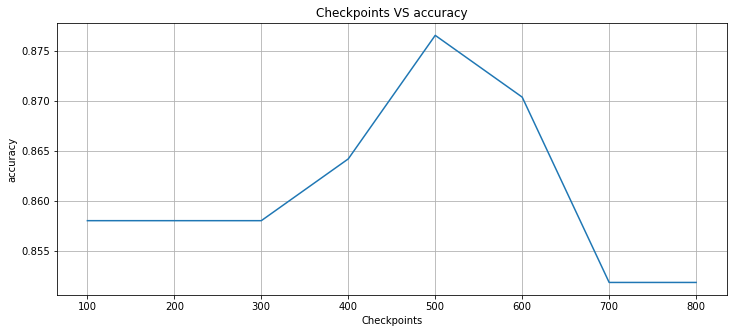

In [11]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.8652132 ]
 [0.11363833]
 [0.02114844]]
[0. 1. 0.] <-> [[0.49164048]
 [0.2671806 ]
 [0.24117896]]
[1. 0. 0.] <-> [[0.44040406]
 [0.32161692]
 [0.23797904]]
[1. 0. 0.] <-> [[0.39697507]
 [0.36422488]
 [0.23880003]]
[1. 0. 0.] <-> [[0.49401978]
 [0.26563114]
 [0.24034905]]
[1. 0. 0.] <-> [[0.7749585 ]
 [0.1665352 ]
 [0.05850633]]
[1. 0. 0.] <-> [[0.9047974 ]
 [0.08306572]
 [0.01213688]]
[0. 0. 1.] <-> [[0.33866012]
 [0.41378075]
 [0.2475591 ]]
[1. 0. 0.] <-> [[0.922537  ]
 [0.06363397]
 [0.01382902]]
[1. 0. 0.] <-> [[0.9053613 ]
 [0.03213086]
 [0.06250786]]
[0. 0. 1.] <-> [[0.02511261]
 [0.5402349 ]
 [0.43465248]]
[1. 0. 0.] <-> [[0.91205883]
 [0.07632399]
 [0.01161724]]
[1. 0. 0.] <-> [[0.64161414]
 [0.21771115]
 [0.14067475]]
[1. 0. 0.] <-> [[0.918997  ]
 [0.03848799]
 [0.04251496]]
[1. 0. 0.] <-> [[0.923897  ]
 [0.04301267]
 [0.03309022]]
[1. 0. 0.] <-> [[0.50587296]
 [0.25912586]
 [0.23500119]]
[1. 0. 0.] <-> [[0.92667115]
 [0.05146153]
 [0.02186735]]
[1. 0. 0.] <->

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[ 3.        ]
 [ 1.1897893 ]
 [ 2.7439473 ]
 [ 3.        ]
 [-0.08484554]]
 bias: [1.838019]

Neuron 1: weights:
[[ 0.619339  ]
 [-0.11617764]
 [ 1.9853629 ]
 [-1.6165915 ]
 [-0.02567919]]
 bias: [-3.]

Neuron 2: weights:
[[ 1.8759681]
 [-2.4782462]
 [-1.0224644]
 [-0.6710992]
 [ 0.5588866]]
 bias: [3.]

Neuron 3: weights:
[[-0.53467166]
 [ 3.        ]
 [-1.0890788 ]
 [ 0.99131304]
 [-0.4357896 ]]
 bias: [1.5949441]

$
Layer 2
Neuron 0: weights:
[[-1.5389847 ]
 [-1.6153631 ]
 [ 1.4282796 ]
 [ 0.80722934]]
 bias: [-3.]

Neuron 1: weights:
[[-0.05240437]
 [-0.76345915]
 [-2.0747044 ]
 [ 2.0798347 ]]
 bias: [-2.945206]

Neuron 2: weights:
[[ 3.       ]
 [ 2.3663635]
 [-1.0097764]
 [-2.7065907]]
 bias: [-3.]

$

